# 颜色空间的转换-RGB和HSI

## RGB转换为HSI

1. RGB 向HSI 模型的转换是由一个基于笛卡尔直角坐标系的单位立方体向基于圆柱极坐标的双锥体的转换。基本要求是将RGB 中的亮度因素分离，将色度分解为色调和饱和度，并用角向量表示色调，如图所示。

![](doc_imgs/11.jpg)

RGB 转换至HSI的几种常见方法:

![](doc_imgs/12.jpg)

转换关系如下:

![](doc_imgs/13.jpg)

实现代码如下：

In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pyexcel_xls import get_data

In [4]:
src = cv2.cvtColor(cv2.imread('../datas/f2.jpg'),cv2.COLOR_BGR2RGB)

In [13]:
import pandas as pd
from pandas import DataFrame
def rgb2hsi(src):
    rgb = np.float64(src)
    r = rgb[:,:,0] / 255
    g = rgb[:,:,1] / 255
    b = rgb[:,:,2] / 255
    
    hsi = np.zeros_like(rgb)
    eps = 1.0e-5
    num = 0.5 * ((r - g) + (r - b))
    den = np.sqrt((r - g) ** 2 + (r - b) * (g - b))
    theta = np.arccos(num / (den + eps)) # 防止除零
    
    H = theta
    H[b > g] = 2 * np.pi - H[b > g]
    H = H / (2 * np.pi)
    num = cv2.min(cv2.min(r,g),b)

    den = r + g + b
    den[den == 0] = eps
    S = 1 - 3.0 * num / den
    H[S == 0] = 0
    I = (r + g + b) / 3
    hsi[:,:,0] = H * 255
    hsi[:,:,1] = S * 255
    hsi[:,:,2] = I * 255
    return hsi

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

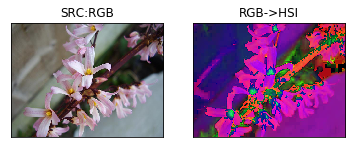

In [14]:
hsi = rgb2hsi(src)
plt.subplot(121)
plt.imshow(src)
plt.title('SRC:RGB')
plt.xticks([]),plt.yticks([])
plt.subplot(122)
plt.imshow(cv2.convertScaleAbs(hsi))
plt.title('RGB->HSI')
plt.xticks([]),plt.yticks([])

In [15]:
def hsi2rgb(src):
    hsi = np.float32(src) / 255.0
    H = hsi[:,:,0] * 2 * np.pi
    S = hsi[:,:,1]
    I = hsi[:,:,2]
    
    df_H = DataFrame(H)
    
    R = np.zeros_like(H)
    G = np.zeros_like(H)
    B = np.zeros_like(H)
    
    # RG扇形(0 <= H < 2*pi/3)
    idx = (df_H >= 0.0) & (df_H < 2 * np.pi / 3)
    print(type(idx))
    B[idx] = I[idx] * (1 - S[idx]);
    R[idx] = I[idx] * (1 + S[idx] * np.cos(H[idx]) / np.cos(np.pi/3 - H[idx]));
    G[idx] = 3*I[idx] - (R[idx] + B[idx]);
    
    # BG扇形(2*pi/3 <= H < 4*pi/3)
    idx = (df_H >= 2 * np.pi / 3) & (df_H < 4 * np.pi / 3)
    R[idx] = I[idx] * (1 - S[idx])
    G[idx] = I[idx] * (1 + S[idx] * np.cos(H[idx] - 2*np.pi/3) / np.cos(np.pi - H[idx]))
    B[idx] = 3*I[idx] - (R[idx] + G[idx])
    
    # BR扇形
    idx = (df_H >= 4 * np.pi / 3) & (df_H <= 2 * np.pi)
    G[idx] = I[idx] * (1 - S[idx])
    B[idx] = I[idx] * (1 + S[idx] * np.cos(H[idx] - 4*np.pi/3) / np.cos(5*np.pi/3 - H[idx]))
    R[idx] = 3*I[idx] - (G[idx] + B[idx])
    
    dst = np.zeros_like(hsi)
   
    dst[:,:,0] = R * 255
    dst[:,:,1] = G * 255
    dst[:,:,2] = B * 255
    return cv2.convertScaleAbs(dst)

<class 'pandas.core.frame.DataFrame'>


(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

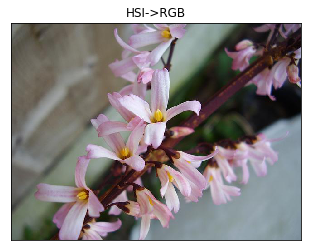

In [18]:
rgb = hsi2rgb(hsi)
plt.imshow(rgb)
plt.title('HSI->RGB')
plt.xticks([]),plt.yticks([])

参考:

[1].http://blog.sina.com.cn/s/blog_a5b3ed560100yo26.html

[2].https://blog.csdn.net/lwplwf/article/details/77494072